In [1]:
import bussilab
import scipy
from scipy.optimize import minimize
import cudamat as cm
import numpy as np
np.random.seed(1995)
import os
curr_dir=os.getcwd()
import gc

from random import choices
import pickle

In [2]:
"""
Tools to perform reweighting using MaxEnt.
"""
import sys
from typing import Optional, Callable
import numpy as np
from scipy.optimize import minimize
from bussilab import coretools

try:
    import cudamat as cm  # pylint: disable=import-error
    _HAS_CUDAMAT=True
except ModuleNotFoundError:
    _HAS_CUDAMAT=False


class MaxentResult(coretools.Result):
    """Result of a `bussilab.maxent.maxent` calculation."""
    def __init__(self,
                 *,
                 logW_ME: np.ndarray,
                 lambdas: np.ndarray,
                 averages: np.ndarray,
                 gamma: float,
                 success: bool,
                 message: str,
                 nfev: int,
                 nit: int):
        super().__init__()
        self.logW_ME = logW_ME
        """`np.ndarray` with `traj.shape[0]` elements, logarithms of the optimized weights."""
        self.lambdas = lambdas
        """`np.ndarray` with `len(reference)` elements, optimized Lagrangian multipliers."""
        self.averages = averages
        """`np.ndarray` with `len(reference)` elements, resulting averages."""
        self.gamma = gamma
        """`float` containing the resulting likelihood Gamma."""
        self.success = success
        """`bool` reporting the success of the minimizer."""
        self.message = message
        """`str` reporting the possible reason of failuer of the minimizer."""
        self.nfev = nfev
        """`int` reporting the number of function evaluations."""
        self.nit = nit
        """`int` reporting the number of iterations in the minimization procedure."""

# Internal tool
# should be called before sum() calls in cudamat
def _ensure_ones(min_size):
    if cm.CUDAMatrix.ones.shape[0]<min_size:
        cm.CUDAMatrix.ones = cm.empty((min_size, 1)).assign(1.0)

def _ensure_cm_init():
    if not hasattr(cm.CUDAMatrix, 'ones'):
        cm.cublas_init()
    elif not isinstance(cm.CUDAMatrix.ones,cm.CUDAMatrix):
        cm.cublas_init()

# Internal tool to compute averages over trajectory.
# Does not access external data.
# Might be optimized on GPU or to access traj from disk.
def _heavy_part(logW: np.ndarray,
                traj: np.ndarray,
                l: np.ndarray,
                weights: bool = False,
                cuda: bool = False):
    if cuda:
        cu_minus_l=cm.CUDAMatrix(np.reshape(-l,(-1,1)))
        logW_ME = cm.dot(traj,cu_minus_l)
        logW_ME.add(logW)
        shift_ME = logW_ME.max(0).asarray()[0,0]
        logW_ME.subtract(float(shift_ME))
        if weights:
            save_logW_ME=logW_ME.copy()
        cm.exp(logW_ME)
        _ensure_ones(logW_ME.shape[0])
        Z=logW_ME.sum(0).asarray()[0,0]
        averages = cm.dot(logW_ME.transpose(),traj).asarray()[0,:]
        averages=np.array(averages,dtype="float64")/Z
        logZ = np.log(Z) + shift_ME
        if not weights:
            return (logZ, averages)
        save_logW_ME.subtract(float(np.log(Z)))
        return (logZ, averages, save_logW_ME.asarray()[:,0])
    else:
        logW_ME = logW-np.dot(traj, l)  # maxent correction
        shift_ME = np.max(logW_ME)  # shift to avoid overflow
        W_ME = np.exp(logW_ME - shift_ME)
        # Partition function:
        Z = np.sum(W_ME)
        # Averages:
        averages = np.dot(W_ME, traj) / Z
        logZ = np.log(Z) + shift_ME
        if not weights:
            return (logZ, averages)
        # only return weights if requested:
        logW_ME -= np.log(Z)+shift_ME
        return (logZ, averages, logW_ME)


def maxent(
        traj,
        reference,
        *,
        logW=None,
        maxiter: int = 1000,
        verbose: bool =False,
        lambdas=None,
        l2=None,
        l1=None,
        method: str = "L-BFGS-B",
        regularization: Optional[Callable] = None,
        tol: Optional[float] = None,
        options=None,
        cuda=False):
    """Tool that computes new weights to enforce reference values.

       This tools process a an array containing the observables computed along a trajectory and
       returns new weights that satisfy the maximum entropy principle and so that weighted averages
       agree with reference values.

       Parameters
       ----------

       traj : array_like
           A 2D array (lists or tuples are internally converted to numpy arrays).
           `traj[i,j]` is j-th observable computed in the i-th frame.
           If traj is a CUDAMatrix object, then cudamat is used irrespectively of the
           bool parameter `cuda`.

       reference : array_like

           A 1D array (lists or tuples are internally converted to numpy arrays)
           containing the reference values to be enforced. If the i-th element is a tuple
           or an array with 2 elements, they are interpreted as boundaries. For instance,
           `reference=[1.0,(2.0,3.0)]` will make sure the first observable has value 1 and
           the second observable is within the range (2,3). Boundaries equal to `+np.inf`
           or `-np.inf` can be used to imply no boundary. Notice that boundaries in the
           form (A,B) where both A and B are finite are implemented by adding fictitious
           variables in a way that is transparent to the user.  Boundaries in the form
           (A,B) where one of A or B is finite and the other is infinite are implemented
           as boundaries on lambdas.  Boundaries in the form (A,A) are interpreted as
           constraints.

       logW : array_like

           A 1D array (lists or tuples are internally converted to numpy arrays)
           containing the logarithm of the a priori weight of the provided frames.

       lamdbas : array_like

           A 1D array with initial values of lambda. A good guess will minimize faster. A
           typical case would be recycling the lambdas obtained with slighlty different
           regularization parameters.

       l2 : None, float, or array_like

           Prefactor for L2 regularization. If None, no regularization is applied. If
           float, the same factor is used on all the lambdas.  If it is an array, it
           should have length equal to `len(reference)`.

       l1 : None, float, or array_like

           Prefactor for L1 regularization. If None, no regularization is applied. If
           float, the same factor is used on all the lambdas.  If it is an array, it
           should have length equal to `len(reference)`.

       regularization : callable or None

           A function that takes as argument the current lambdas and return an tuple
           containing the regularization function and its derivatives. For instance,
           passing a function defined as
           `def reg(x): return (0.0001*0.5*np.sum(x**2),0.0001*x)`
           is equivalent to passing `l2=0.0001`.

       verbose : bool
           If True, progress informations are written on stdout.

       method : str
           Minimization method. See documentation of `scipy.optimize.minimize`.

       maxiter : int
           Maximum number of iterations

       tol : float or None
           Tolerance for minimization. See documentation of scipy.optimize.minimize.

       options : dict
           Arbitrary options passed to `scipy.optimize.minimize`.

       cuda : bool or None (default False)
           Use cuda. If None, chosen based on the availability of the cudamat library.

       Notes on using CUDA
       -------------------

       Note that for normal datasets the cost of transfering the traj object to
       the GPU dominates. It it however possible to transfer the traj object first to the GPU
       with `cu_traj=cm.CUDAMatrix(traj)` and then reuse it for multiple calls
       (e.g. for a hyper parameter scan).

    """

    if cuda is None:
        cuda = _HAS_CUDAMAT

    # when a cudamatrix is passed, cuda is enabled by default
    if _HAS_CUDAMAT:
        if isinstance(traj,cm.CUDAMatrix):
            cuda=True

    if cuda:
        if not _HAS_CUDAMAT:
            raise ValueError("Cudamat not available, can only run ANN with numpy")
        _ensure_cm_init()
        if isinstance(traj,cm.CUDAMatrix):
            cu_traj=traj
        else:
            traj = coretools.ensure_np_array(traj)
            cu_traj=cm.CUDAMatrix(traj)
    else:
        traj = coretools.ensure_np_array(traj)

    lambdas = coretools.ensure_np_array(lambdas)

    nframes = traj.shape[0]
    nobs = traj.shape[1]

    # accepts a scalar as l2 regularization term
    if isinstance(l2, float):
        l2 = np.ones(nobs)*l2

    l2 = coretools.ensure_np_array(l2)

    if isinstance(l1, float):
        l1 = np.ones(nobs)*l1

    l1 = coretools.ensure_np_array(l1)
    # default values
    if logW is None:
        logW = np.zeros(nframes)
    if lambdas is None:
        lambdas = np.zeros(nobs)

    # checks
    assert len(reference) == nobs
    assert len(logW) == nframes
    assert len(lambdas) == nobs

    fullreference = []
    bounds = []
    box_const = []
    for i in range(nobs):
        if hasattr(reference[i], "__len__"):
            if len(reference[i]) > 1:
                if len(reference[i]) > 2:
                    raise TypeError("")
                if reference[i][0] > reference[i][1]:
                    raise TypeError("")
                if reference[i][0] == reference[i][1]:
                    fullreference.append(reference[i][0])
                    bounds.append((-np.inf, +np.inf))
                    box_const.append(False)
                elif (np.isinf(reference[i][1]) and reference[i][1] > 0.0
                      and not np.isinf(reference[i][0])):
                    fullreference.append(reference[i][0])
                    bounds.append((-np.inf, 0.0))
                    box_const.append(False)
                elif (np.isinf(reference[i][0]) and reference[i][0] < 0.0
                      and not np.isinf(reference[i][1])):
                    fullreference.append(reference[i][1])
                    bounds.append((0.0, +np.inf))
                    box_const.append(False)
                elif not np.isinf(reference[i][0]) and not np.isinf(reference[i][1]):
                    fullreference.append(reference[i][0])
                    fullreference.append(reference[i][1])
                    bounds.append((-np.inf, 0.0))
                    bounds.append((0.0, +np.inf))
                    box_const.append(True)
                elif ((np.isinf(reference[i][0]) and reference[i][0] < 0.0)
                      and (np.isinf(reference[i][1]) and reference[i][1] > 0.0)):
                    fullreference.append(0.0)
                    bounds.append((0.0, 0.0))
                    box_const.append(False)
                else:
                    raise TypeError("")
            else:
                fullreference.append(reference[i][0])
                bounds.append((-np.inf, +np.inf))
                box_const.append(False)
        else:
            fullreference.append(reference[i])
            bounds.append((-np.inf, +np.inf))
            box_const.append(False)


    # to fix these, use np.asarray, only available in numpy 1.20.0
    fullreference = np.array(fullreference)  # type: ignore
    bounds = np.array(bounds)  # type: ignore
    box_const = np.array(box_const)  # type: ignore

    nit = 0
    def _callback(par):
        nonlocal nit  # needed to access outer scope
        nit += 1
        if verbose:
            sys.stderr.write("MAXENT: iteration "+str(nit)+"\n")

    callback: Optional[Callable] = None
    # verbose logging
    if verbose:
        sys.stderr.write("MAXENT: start\n")
        callback = _callback

    # logZ0 is not changing during minimization and is computed once.
    # it is only needed to compute Gamma
    shift0 = np.max(logW)  # shift to avoid overflow
    W0 = np.exp(logW - shift0)
    logZ0 = np.log(np.sum(W0)) + shift0

    if cuda:
        cu_logW=cm.CUDAMatrix(np.reshape(logW,(-1,1)))

    # function to be minimized
    def func(l):

        l = np.array(l)  # ensure array

        assert len(l) == len(fullreference)

        # takes care of >< constraints
        # vector ll only contains the Lagrangian multipliers to be applied on the trajectory
        if len(fullreference) != nobs:
            ll = np.zeros(nobs)
            s = 0
            for i in range(nobs):
                if box_const[i]:
                    # >< multipliers are summed
                    ll[i] = l[i+s] + l[i+s+1]
                    s += 1
                else:
                    ll[i] = l[i+s]
        else:
            ll = l


        if cuda:
            logZ, averages = _heavy_part(cu_logW, cu_traj, ll, cuda=cuda)
        else:
            logZ, averages = _heavy_part(logW, traj, ll, cuda=cuda)


        f = logZ - logZ0
        der = -averages


        if regularization is not None:
            reg = regularization(ll)
            f += reg[0]
            der += reg[1]

        if l2 is not None:
            f += 0.5*np.sum(l2*ll**2)
            der += l2*ll

        if l1 is not None:
            eee = 1e-50
            f += np.sum(l1*np.sqrt(ll**2+eee**2))
            der += l1*ll/np.sqrt(ll**2+eee**2)

        # takes care of >< constraints
        # vector der only contains the nobs elements
        # it is here extended
        if len(fullreference) != nobs:
            newder = np.zeros(len(fullreference))
            s = 0
            for i in range(nobs):
                if box_const[i]:
                    newder[i+s] = der[i]
                    newder[i+s+1] = der[i]
                    s += 1
                else:
                    newder[i+s] = der[i]
            der = newder

        # fullreference contains already nobs+nshift elements
        f += np.dot(l, fullreference)
        der += fullreference

        return(f, der)


    # With >< constraints the initial lambdas should be fixed
    if len(fullreference) != nobs:
        ll = np.zeros(len(fullreference))
        s = 0
        for i in range(nobs):
            if box_const[i]:
                if lambdas[i] >= 0:
                    ll[i+s+1] = lambdas[i]
                else:
                    ll[i+s] = lambdas[i]
                s += 1
            else:
                ll[i+s] = lambdas[i]
        lambdas = ll

    if maxiter is not None:
        if options is None:
            options = {}
        options["maxiter"] = maxiter

    res = minimize(
        func, lambdas, method=method, jac=True, callback=callback, bounds=bounds,
        tol=tol, options=options)

    # With >< constraints the final lambdas should be fixed
    if len(fullreference) != nobs:
        lambdas = np.zeros(nobs)
        s = 0
        for i in range(nobs):
            if box_const[i]:
                lambdas[i] = res.x[i+s]+res.x[i+s+1]
                s += 1
            else:
                lambdas[i] = res.x[i+s]
    else:
        lambdas = res.x

    # recompute weights at the end
    if cuda:
        logZ, averages, logW_ME = _heavy_part(cu_logW, cu_traj, lambdas, weights=True, cuda=cuda)
    else:
        logZ, averages, logW_ME = _heavy_part(logW, traj, lambdas, weights=True)

    if verbose:
        sys.stderr.write("MAXENT: end\n")

    return MaxentResult(
        logW_ME=logW_ME,
        lambdas=lambdas,
        averages=averages,
        gamma=res.fun,
        success=res.success,
        message=res.message,
        nfev=res.nfev,
        nit=res.nit
    )

In [4]:
Sequences=['AAAA','CAAU','GACC','CCCC','UUUU','UCAAUC']

In [5]:
#instead of heavy atoms the hydrogens are used for dihedral angle computation in this script

In [6]:
def _relu(x):
    return np.maximum(x,0)

def _drelu(x):
    return np.heaviside(x,0.5)


def func_grad(par,opt=True,regularize=True):
    
    func=0
    grad=np.zeros(par.shape)
    chi2_func=0
    chi2_grad=np.zeros(par.shape)
    gamma_func=0
    gamma_grad=np.zeros(par.shape)
    new_chi_list=[]
    
    new_weights_list=[]
    new_lambdas_list=[]
    
    for s,Sequence in enumerate(Sequences):

        gamma_jcoupl_components=func_grad.gamma_jcoupl_components_list[s][:,func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_gamma[s]]
        beta_jcoupl_components=func_grad.beta_jcoupl_components_list[s][:,func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_beta[s]]
        sugar_jcoupl_components=func_grad.sugar_jcoupl_components_list[s][:,func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_sugar[s]]

        gamma_jcoupl_components/=func_grad.backbone1_exp_list[s][:,1][np.newaxis,func_grad.selection_obs_gamma[s]]
        beta_jcoupl_components/=func_grad.backbone2_exp_list[s][:,1][np.newaxis,func_grad.selection_obs_beta[s]]
        sugar_jcoupl_components/=func_grad.sugar_exp_list[s][:,1][np.newaxis,func_grad.selection_obs_sugar[s]]
        
        new_backbone1_coupl=np.einsum('i,ijk->jk',par[0:3],gamma_jcoupl_components)
        new_backbone2_coupl=np.einsum('i,ijk->jk',par[3:6],beta_jcoupl_components)
        new_sugar_coupl=np.einsum('i,ijk->jk',par[6:9],sugar_jcoupl_components)
        
        jscalar_couplings=np.hstack((new_backbone1_coupl,new_backbone2_coupl,new_sugar_coupl))
        
        noe=np.copy(func_grad.noe_list[s])[func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_noe[s]]/func_grad.noe_exp_list[s][:,1][np.newaxis,func_grad.selection_obs_noe[s]]
        unoe=np.copy(func_grad.unoe_list[s])[func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_unoe[s]]/np.array(func_grad.unoe_exp_list[s][:,1],dtype=float)[np.newaxis,func_grad.selection_obs_unoe[s]]
        
        
        simulations_data=np.hstack((jscalar_couplings,noe,unoe))
        exp_data=func_grad.exp_data_list[s][func_grad.selection_obs[s]] 
        
        m=maxent(simulations_data,exp_data,l2=func_grad.alpha, cuda=cuda)
        new_lambdas_list.append(m.lambdas)

        Gamma=m.gamma
        new_weights=np.exp(m.logW_ME)
        new_weights_list.append(new_weights) 

        gamma_func+=-func_grad.alpha*Gamma
            
        if opt==True:
            
            ave_der_backbone1=np.einsum('i,jik->jk',new_weights,gamma_jcoupl_components)
            ave_der_backbone2=np.einsum('i,jik->jk',new_weights,beta_jcoupl_components)
            ave_der_sugar=np.einsum('i,jik->jk',new_weights,sugar_jcoupl_components)

            backbone1_lambdas=ave_der_backbone1.shape[1]
            backbone2_lambdas=backbone1_lambdas+ave_der_backbone2.shape[1]
            sugar_lambdas=backbone2_lambdas+ave_der_sugar.shape[1]
            
            temp_grad=[[],[],[]]
            temp_grad[0]=np.einsum('i,ji->j',m.lambdas[0:backbone1_lambdas],ave_der_backbone1)
            temp_grad[1]=np.einsum('i,ji->j',m.lambdas[backbone1_lambdas:backbone2_lambdas],ave_der_backbone2)
            temp_grad[2]=np.einsum('i,ji->j',m.lambdas[backbone2_lambdas:sugar_lambdas],ave_der_sugar)

            gamma_grad+=func_grad.alpha*np.array(temp_grad).flatten()
            
    
    func+=gamma_func
    grad+=gamma_grad

    func/=len(Sequences) 
    grad/=len(Sequences) 

    #add regularization 
    if regularize ==True:
        
        if regularization=='L2':
            func+=func_grad.hyperparameter*np.sum((par-Karplus_parameters_transformed)**2)
            grad+=func_grad.hyperparameter*2*(par-Karplus_parameters_transformed)

    if opt==True:
        return func,grad

    else:
        return np.array(new_chi_list)/func_grad.M,new_weights_list,new_lambdas_list #,new_gamma_list

In [ ]:
#to load data successfully download files from https://zenodo.org/record/7746293
#create a dir 'dataload'
#create subdir for each system in ['AAAA','CAAU','GACC','CCCC','UUUU','UCAAUC']
#place corresponding files into the respective subdir

In [ ]:
#load experimental data
M=0
#we choose an assumed experimental error for jcoupling data:
sigma_exp=0.3 
def read_exp(path, columns):
    matrix=[]
    for col in range(columns):
        matrix.append([])
    with open(path, 'r') as f:
        for line in f:
            if '#' not in line:
                nums=line.split()
                for col in range(columns):
                    matrix[col].append(nums[col])
    return np.array(matrix)

func_grad.backbone1_exp_list=[]
func_grad.backbone2_exp_list=[]
func_grad.sugar_exp_list=[]

func_grad.noe_exp_list=[]
func_grad.unoe_exp_list=[]

for s,Sequence in enumerate(Sequences):
    print(Sequence)
    j3_data=read_exp(curr_dir+'/dataload/%s/j3_%s.exp.dat' %(Sequence,Sequence),3 )
    

    backbone1_exp=[]
    backbone2_exp=[]
    sugar_exp=[]
    for e,elem in enumerate(j3_data.T):
        #print(elem[0])
        if '1H5H4' in elem[0] or '2H5H4'in elem[0]:
            backbone1_exp.append([float(elem[1]),float(sigma_exp)])
        if '1H5P' in elem[0] or '2H5P' in elem[0] or 'H3P' in elem[0]:
            backbone2_exp.append([float(elem[1]),float(sigma_exp)])
        if 'H1H2'  in elem[0] or 'H2H3' in elem[0] or 'H3H4' in elem[0]:
            sugar_exp.append([float(elem[1]),float(sigma_exp)])

    backbone1_exp=np.array(backbone1_exp)
    if 'CAAU' in Sequence:
        backbone2_exp=np.array(backbone2_exp[:-1])
    else:
        backbone2_exp=np.array(backbone2_exp)
    sugar_exp=np.array(sugar_exp)

    print(backbone1_exp.shape)
    print(backbone2_exp.shape)
    print(sugar_exp.shape)
    func_grad.backbone1_exp_list.append(backbone1_exp)
    func_grad.backbone2_exp_list.append(backbone2_exp)
    func_grad.sugar_exp_list.append(sugar_exp)
    
    #NOE and uNOE
    if Sequence!='UCAAUC':
        if Sequence=='CAAU':
            unoe_data=read_exp(curr_dir+'/dataload/%s/formatted_unoe_%s.exp.dat' %(Sequence,Sequence),4 )
        else:
            unoe_data=read_exp(curr_dir+'/dataload/%s/unoe_%s.exp.dat' %(Sequence,Sequence),4 )
        noe_data=read_exp(curr_dir+'/dataload/%s/noe_%s.exp.dat' %(Sequence,Sequence),5 )

        noe_exp=noe_data.T[:,2:]
        unoe_exp=unoe_data.T[:,2:]
        noe_exp=noe_exp[:,:].astype(float)

        
    
    else:
        noe_data=read_exp(curr_dir+'/dataload/%s/formatted_noe_%s.exp.dat' %(Sequence,Sequence),5 )
        unoe_data=read_exp(curr_dir+'/dataload/%s/formatted_unoe_%s.exp.dat' %(Sequence,Sequence),4 )
        #special noe treatment, because the experimental data required summing some signals
        lines_to_ignore=[2, 4, 6, 8, 10, 12, 14, 16, 19, 26, 29, 32, 39]

        for index in sorted(lines_to_ignore, reverse=True):
            noe_data=np.delete(noe_data,index,1)
        
        noe_exp=noe_data.T[:,2:]
        unoe_exp=unoe_data.T[:,2:]
        noe_exp=noe_exp[:,:].astype(float)
        
    temp=[]
    for i in range(noe_exp.shape[0]):
        temp.append([noe_exp[i,1],np.min([noe_exp[i,2]-noe_exp[i,1],noe_exp[i,1]-noe_exp[i,0]])])
    noe_exp=np.array(temp)
    unoe_exp=unoe_exp[:,:].astype(float)

    print(noe_exp.shape)
    print(unoe_exp.shape)

    func_grad.noe_exp_list.append(noe_exp)
    
    #change to NOE signal
    noe_exp=np.copy(func_grad.noe_exp_list[s])
    
    exp_noe=noe_exp[:,0]**(-6)
    a=np.abs((noe_exp[:,0]-noe_exp[:,1])**(-6)-noe_exp[:,0]**(-6))
    b=np.abs((noe_exp[:,0]+noe_exp[:,1])**(-6)-noe_exp[:,0]**(-6))
    exp_noe_std=(a+b)/2
    
    func_grad.noe_exp_list[s][:,0]=exp_noe
    func_grad.noe_exp_list[s][:,1]=exp_noe_std
    
    temp=[]
    for e,elem in enumerate(unoe_exp):
        temp.append([(unoe_exp[e][0],+np.inf),unoe_exp[e][1]])

    unoe_exp=np.array(temp,dtype='object')
    func_grad.unoe_exp_list.append(unoe_exp)
    
    #change to NOE signal
    unoe_exp_temp=np.copy(unoe_exp)
    
    exp_unoe=[]
    exp_unoe_std=[]
    for e,elem in enumerate(unoe_exp[:,0]):
        func_grad.unoe_exp_list[s][e,0]=(0,unoe_exp_temp[e,0][0]**(-6))
        func_grad.unoe_exp_list[s][e,1]=np.abs((unoe_exp_temp[e,0][0]-unoe_exp_temp[e,1])**(-6)-unoe_exp_temp[e,0][0]**(-6))
    
    
    M+=backbone1_exp.shape[0]+backbone2_exp.shape[0]+sugar_exp.shape[0]+noe_exp.shape[0]+unoe_exp.shape[0]
print('number of experiments: ',M)

In [ ]:
#Karplus parameters contains A,B and C for gamma, beta and sugar in this order
Karplus_parameters=np.array([[9.7,-1.8,0],[15.3,-6.1,1.6],[9.67,-2.03,0]])

def transform_Karplus(par):
    new_par=[]
    for elem in par:
        A=elem[0]
        B=elem[1]
        C=elem[2]

        A_T=A/2
        B_T=B
        C_T=np.sqrt(2)*(C+A/2)
        new_par.append([A_T,B_T,C_T])
    return np.array(new_par).flatten(),par.flatten()

Karplus_parameters_transformed,Karplus_parameters=transform_Karplus(Karplus_parameters)

func_grad.gamma_jcoupl_components_list=[]
func_grad.beta_jcoupl_components_list=[]
func_grad.sugar_jcoupl_components_list=[]
func_grad.noe_list=[]
func_grad.unoe_list=[]


for s,Sequence in enumerate(Sequences):
    print(Sequence)
    gamma_angle=np.load(curr_dir+'/dataload/%s/MaxEnt_gamma_angle_%s_300K.npy' %(Sequence,Sequence))
    beta_angle=np.load(curr_dir+'/dataload/%s/MaxEnt_beta_angle_%s_300K.npy' %(Sequence,Sequence))
    sugar_angle=np.load(curr_dir+'/dataload/%s/MaxEnt_sugar_angle_%s_300K.npy' %(Sequence,Sequence))
    
    gamma_angle=gamma_angle[:int(1e6)]
    beta_angle=beta_angle[:int(1e6)]
    sugar_angle=sugar_angle[:int(1e6)]
    
    gamma_jcoupl_components=np.array([np.cos(2*gamma_angle),np.cos(gamma_angle),np.ones(gamma_angle.shape)/np.sqrt(2)])
    beta_jcoupl_components=np.array([np.cos(2*beta_angle),np.cos(beta_angle),np.ones(beta_angle.shape)/np.sqrt(2)])
    sugar_jcoupl_components=np.array([np.cos(2*sugar_angle),np.cos(sugar_angle),np.ones(sugar_angle.shape)/np.sqrt(2)])
    
    backbone1_coupl=np.einsum('i,ijk->jk',Karplus_parameters_transformed[0:3],gamma_jcoupl_components)
    backbone2_coupl=np.einsum('i,ijk->jk',Karplus_parameters_transformed[3:6],beta_jcoupl_components)
    sugar_coupl=np.einsum('i,ijk->jk',Karplus_parameters_transformed[6:9],sugar_jcoupl_components)

    
    #NOEs
    noe = np.load(curr_dir+"/dataload/%s/noe6m_%s_300K.npy" %(Sequence,Sequence))
    unoe = np.load(curr_dir+"/dataload/%s/unoe6m_%s_300K.npy" %(Sequence,Sequence))

    noe=noe.reshape(-1,noe.shape[1])
    unoe=unoe.reshape(-1,unoe.shape[1])
    noe=noe[:int(1e6),:]
    unoe=unoe[:int(1e6),:]
    
    
    skip=100
    prune=False
    if prune==True:
        gamma_angle=gamma_angle[::skip,:]
        beta_angle=beta_angle[::skip,:]
        sugar_angle=sugar_angle[::skip,:]
        gamma_jcoupl_components=gamma_jcoupl_components[:,::skip,:]
        beta_jcoupl_components=beta_jcoupl_components[:,::skip,:]
        sugar_jcoupl_components=sugar_jcoupl_components[:,::skip,:]
        noe=noe[::skip,:]
        unoe=unoe[::skip,:]
        
        gc.collect()
        
    print(gamma_angle.shape)
    print(beta_angle.shape)
    print(sugar_angle.shape)
    print(gamma_jcoupl_components.shape)
    print(beta_jcoupl_components.shape)
    print(sugar_jcoupl_components.shape)
    
    print(noe.shape)
    print(unoe.shape)

    
    func_grad.gamma_jcoupl_components_list.append(gamma_jcoupl_components)
    func_grad.beta_jcoupl_components_list.append(beta_jcoupl_components)
    func_grad.sugar_jcoupl_components_list.append(sugar_jcoupl_components)
    func_grad.noe_list.append(noe)
    func_grad.unoe_list.append(unoe)
    

In [ ]:
#remove 20% of all the NOE observables are excluded to be used as a 'true' validation

#the files needed for CV analysis can be found in 'CV_files'
#also thos, place them in your 'dataload' dir

In [ ]:
#when training
training_set_selection=np.load(curr_dir+'/dataload/CV207030_training_set_selection_300K.npy')

#when validating the new Karplus parameters
#true_validation_selection=np.load('curr_dir+'/dataload/CV207030_true_validation_selection_300K.npy')

def true_validation_selector(obs,sel,shape_ndx):
    applied_selection=sel[sel<obs.shape[shape_ndx]]
    sel-=obs.shape[shape_ndx]
    sel=sel[sel >= 0]
    
    return sel,np.array(applied_selection,dtype=np.int) 

temp_sel_exp=np.copy(training_set_selection)
temp_sel_sim=np.copy(training_set_selection)
for s,Sequence in enumerate(Sequences):
    
    #experiments
    temp_sel_exp,applied_selection=true_validation_selector(func_grad.noe_exp_list[s],temp_sel_exp,0)
    func_grad.noe_exp_list[s]=func_grad.noe_exp_list[s][applied_selection]
    temp_sel_exp,applied_selection=true_validation_selector(func_grad.unoe_exp_list[s],temp_sel_exp,0)
    func_grad.unoe_exp_list[s]=func_grad.unoe_exp_list[s][applied_selection]
    #simulation data
    
    temp_sel_sim,applied_selection=true_validation_selector(func_grad.noe_list[s],temp_sel_sim,1)
    func_grad.noe_list[s]=func_grad.noe_list[s][:,applied_selection]
    temp_sel_sim,applied_selection=true_validation_selector(func_grad.unoe_list[s],temp_sel_sim,1)
    func_grad.unoe_list[s]=func_grad.unoe_list[s][:,applied_selection]
    
    print(func_grad.noe_exp_list[s].shape)
    print(func_grad.unoe_exp_list[s].shape)
    print(func_grad.noe_list[s].shape)
    print(func_grad.unoe_list[s].shape)
    

In [ ]:
func_grad.exp_jscalar_couplings_list=[]
func_grad.exp_data_list=[]

func_grad.M=0
for s,Sequence in enumerate(Sequences):
    
    exp_jscalar_couplings=np.vstack((func_grad.backbone1_exp_list[s],func_grad.backbone2_exp_list[s],func_grad.sugar_exp_list[s]))
    exp_data=np.vstack((exp_jscalar_couplings,func_grad.noe_exp_list[s],func_grad.unoe_exp_list[s]))
    
    scal_rng=exp_jscalar_couplings.shape[0]
    noe_rng=scal_rng+func_grad.noe_exp_list[s].shape[0]
    scalar_coupl_temp=exp_data[:scal_rng,0]/exp_data[:scal_rng,1]
    noe_temp=exp_data[scal_rng:noe_rng,0]/exp_data[scal_rng:noe_rng,1]
    unoe_temp=[]
    for elem in exp_data[noe_rng:]:
        unoe_temp.append((elem[0][0],elem[0][1]/elem[1]))
    print(len(unoe_temp))
    for e,elem in enumerate(exp_data):
        if e < scal_rng:
            exp_data[e]=[scalar_coupl_temp[e],exp_data[e][1]]
        if e >= scal_rng and e < noe_rng:
            ndx=e-scal_rng
            exp_data[e]=[noe_temp[ndx],exp_data[ndx][1]]
        if e >= noe_rng:
            ndx=e-noe_rng
            exp_data[e]=[unoe_temp[ndx],exp_data[ndx][1]]
    
    exp_data=exp_data[:,0]
    
    print(exp_data.shape)
    
    func_grad.exp_jscalar_couplings_list.append(exp_jscalar_couplings)
    func_grad.exp_data_list.append(exp_data)
    
    func_grad.M+=func_grad.exp_data_list[s].shape[0]
print(func_grad.M)

In [ ]:
def compute_weights(par,lambdas,training_frame_selection,validation_frame_selection,cuda):
    
    training_weights_list=[]
    validation_weights_list1=[]
    validation_weights_list2=[]
    for s,Sequence in enumerate(Sequences):
        gamma_jcoupl_components=func_grad.gamma_jcoupl_components_list[s][:,:,func_grad.selection_obs_gamma[s]]
        beta_jcoupl_components=func_grad.beta_jcoupl_components_list[s][:,:,func_grad.selection_obs_beta[s]]
        sugar_jcoupl_components=func_grad.sugar_jcoupl_components_list[s][:,:,func_grad.selection_obs_sugar[s]]

        gamma_jcoupl_components/=func_grad.backbone1_exp_list[s][:,1][np.newaxis,func_grad.selection_obs_gamma[s]]
        beta_jcoupl_components/=func_grad.backbone2_exp_list[s][:,1][np.newaxis,func_grad.selection_obs_beta[s]]
        sugar_jcoupl_components/=func_grad.sugar_exp_list[s][:,1][np.newaxis,func_grad.selection_obs_sugar[s]]
        
        new_backbone1_coupl=np.einsum('i,ijk->jk',par[0:3],gamma_jcoupl_components)
        new_backbone2_coupl=np.einsum('i,ijk->jk',par[3:6],beta_jcoupl_components)
        new_sugar_coupl=np.einsum('i,ijk->jk',par[6:9],sugar_jcoupl_components)
        
        traj_jscalar=np.hstack((new_backbone1_coupl,new_backbone2_coupl,new_sugar_coupl))
        
        #add noes
        noe=np.copy(func_grad.noe_list[s])[:,func_grad.selection_obs_noe[s]]/func_grad.noe_exp_list[s][:,1][np.newaxis,func_grad.selection_obs_noe[s]]
        unoe=np.copy(func_grad.unoe_list[s])[:,func_grad.selection_obs_unoe[s]]/np.array(func_grad.unoe_exp_list[s][:,1],dtype=float)[np.newaxis,func_grad.selection_obs_unoe[s]]
        
        traj=np.hstack((traj_jscalar,noe,unoe))
         
        if cuda==True:
            
            cu_traj=cm.CUDAMatrix(traj)
            
            cu_minus_l=cm.CUDAMatrix(np.reshape(-lambdas[s],(-1,1)))
            all_logW_ME = cm.dot(cu_traj,cu_minus_l).asarray()#[:,0]
            
            #obtain training weights
            np_logW_ME=all_logW_ME[training_frame_selection]
            logW_ME=cm.CUDAMatrix(np_logW_ME)
            shift_ME = logW_ME.max(0).asarray()[0,0]
            logW_ME.subtract(float(shift_ME))
            save_logW_ME=logW_ME.copy()
            cm.exp(logW_ME)
            _ensure_ones(logW_ME.shape[0])
            Z=logW_ME.sum(0).asarray()[0,0]
            logZ = np.log(Z) + shift_ME
            save_logW_ME.subtract(float(np.log(Z)))
            w=np.exp(save_logW_ME.asarray()[:,0])
            training_weights_list.append(w)
            
            #obtain validation weights 1 
            np_logW_ME=all_logW_ME[validation_frame_selection]
            logW_ME=cm.CUDAMatrix(np_logW_ME)
            shift_ME = logW_ME.max(0).asarray()[0,0]
            logW_ME.subtract(float(shift_ME))
            save_logW_ME=logW_ME.copy()
            cm.exp(logW_ME)
            _ensure_ones(logW_ME.shape[0])
            Z=logW_ME.sum(0).asarray()[0,0]
            logZ = np.log(Z) + shift_ME
            save_logW_ME.subtract(float(np.log(Z)))
            w=np.exp(save_logW_ME.asarray()[:,0])
            validation_weights_list1.append(w)
            
            #obtain validation weights 2 
            np_logW_ME=all_logW_ME
            logW_ME=cm.CUDAMatrix(np_logW_ME)
            shift_ME = logW_ME.max(0).asarray()[0,0]
            logW_ME.subtract(float(shift_ME))
            save_logW_ME=logW_ME.copy()
            cm.exp(logW_ME)
            _ensure_ones(logW_ME.shape[0])
            Z=logW_ME.sum(0).asarray()[0,0]
            logZ = np.log(Z) + shift_ME
            save_logW_ME.subtract(float(np.log(Z)))
            w=np.exp(save_logW_ME.asarray()[:,0])
            validation_weights_list2.append(w)
            
            
        else:
            all_logW_ME = -np.dot(traj, lambdas[s])  # maxent correction
            
            #obtain training weights
            logW_ME=all_logW_ME[training_frame_selection]
            shift_ME = np.max(logW_ME)  # shift to avoid overflow
            W_ME = np.exp(logW_ME - shift_ME)
            Z = np.sum(W_ME)
            logZ = np.log(Z) + shift_ME
            logW_ME -= np.log(Z)+shift_ME
            w=np.exp(logW_ME)
            training_weights_list.append(w)

            #obtain validation weights 1 
            logW_ME=all_logW_ME[validation_frame_selection]
            shift_ME = np.max(logW_ME)  # shift to avoid overflow
            W_ME = np.exp(logW_ME - shift_ME)
            Z = np.sum(W_ME)
            logZ = np.log(Z) + shift_ME
            logW_ME -= np.log(Z)+shift_ME
            w=np.exp(logW_ME)
            validation_weights_list1.append(w)
            
            #obtain validation weights 2 
            logW_ME=all_logW_ME
            shift_ME = np.max(logW_ME)  # shift to avoid overflow
            W_ME = np.exp(logW_ME - shift_ME)
            Z = np.sum(W_ME)
            logZ = np.log(Z) + shift_ME
            logW_ME -= np.log(Z)+shift_ME
            w=np.exp(logW_ME)
            validation_weights_list2.append(w)
        
    return training_weights_list,validation_weights_list1,validation_weights_list2
    

In [ ]:
def compute_chi(par,weights_list):
    
    
    chi2=0.0
    chi2_sys_list=[]
    
    #simulation data should be recomputed using the new Karplus parameters and new weights from maxent
    for s,Sequence in enumerate(Sequences):
        
        weights=weights_list[s]
        
        noe=func_grad.noe_list[s][func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_noe[s]]
        unoe=func_grad.unoe_list[s][func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_unoe[s]]
        
        backbone1_exp=func_grad.backbone1_exp_list[s][func_grad.selection_obs_gamma[s]]
        backbone2_exp=func_grad.backbone2_exp_list[s][func_grad.selection_obs_beta[s]]
        sugar_exp=func_grad.sugar_exp_list[s][func_grad.selection_obs_sugar[s]]
        noe_exp=func_grad.noe_exp_list[s][func_grad.selection_obs_noe[s]]
        unoe_exp=func_grad.unoe_exp_list[s][func_grad.selection_obs_unoe[s]]

        gamma_jcoupl_components=func_grad.gamma_jcoupl_components_list[s][:,func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_gamma[s]]
        beta_jcoupl_components=func_grad.beta_jcoupl_components_list[s][:,func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_beta[s]]
        sugar_jcoupl_components=func_grad.sugar_jcoupl_components_list[s][:,func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_sugar[s]]

        new_backbone1_coupl=np.einsum('i,ijk->jk',par[0:3],gamma_jcoupl_components)
        new_backbone2_coupl=np.einsum('i,ijk->jk',par[3:6],beta_jcoupl_components)
        new_sugar_coupl=np.einsum('i,ijk->jk',par[6:9],sugar_jcoupl_components)
        
        pred=np.matmul(weights,new_backbone1_coupl)
        chi2_backbone1=np.sum(((pred-backbone1_exp[:,0])/backbone1_exp[:,1])**2)
        chi2+=chi2_backbone1
        
        pred=np.matmul(weights,new_backbone2_coupl)
        chi2_backbone2=np.sum(((pred-backbone2_exp[:,0])/backbone2_exp[:,1])**2)
        chi2+=chi2_backbone2
        
        pred=np.matmul(weights,new_sugar_coupl)
        chi2_sugar=np.sum(((pred-sugar_exp[:,0])/sugar_exp[:,1])**2)
        chi2+=chi2_sugar
        
        pred=np.matmul(weights,noe)
        chi2_noe=np.sum(((pred-noe_exp[:,0])/noe_exp[:,1])**2)
        chi2+=chi2_noe
        
        pred=np.matmul(weights,unoe)
        chi2_unoe=0.0
        for i in range(len(pred)):
            diff=pred[i]-unoe_exp[i,0][1]
            if(diff>.0):
                chi2_unoe+=(diff/unoe_exp[i,1])**2
        chi2+=chi2_unoe

        chi2_sys_list.append([np.sum([chi2_backbone1,chi2_backbone2,chi2_sugar,chi2_noe,chi2_unoe])/func_grad.M,
                                           chi2_backbone1/func_grad.M,chi2_backbone2/func_grad.M,chi2_sugar/func_grad.M,chi2_noe/func_grad.M,chi2_unoe/func_grad.M])
        
    chi2/=func_grad.M 
    chi2/=len(Sequences) 

    return chi2,chi2_sys_list

In [ ]:
def compute_chi_val(par,weights_list,weights_list2):
    
    
    chi2=0.0
    chi2_sys_list=[]
    
    #one time collect chi2 for validation on remaining frames of obs used in training
    #the 2nd time collect chi2 on obs not used in training but all frames
    for valtype in range(2):
        
        #simulation data should be recomputed using the new Karplus parameters and new weights from maxent
        for s,Sequence in enumerate(Sequences):

            if valtype == 0:
                weights=weights_list[s]
                noe=func_grad.noe_list[s][func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_noe1[s]]
                unoe=func_grad.unoe_list[s][func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_unoe1[s]]

                backbone1_exp=func_grad.backbone1_exp_list[s][func_grad.selection_obs_gamma1[s]]
                backbone2_exp=func_grad.backbone2_exp_list[s][func_grad.selection_obs_beta1[s]]
                sugar_exp=func_grad.sugar_exp_list[s][func_grad.selection_obs_sugar1[s]]
                noe_exp=func_grad.noe_exp_list[s][func_grad.selection_obs_noe1[s]]
                unoe_exp=func_grad.unoe_exp_list[s][func_grad.selection_obs_unoe1[s]]

                gamma_jcoupl_components=func_grad.gamma_jcoupl_components_list[s][:,func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_gamma1[s]]
                beta_jcoupl_components=func_grad.beta_jcoupl_components_list[s][:,func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_beta1[s]]
                sugar_jcoupl_components=func_grad.sugar_jcoupl_components_list[s][:,func_grad.selection_frames[:,np.newaxis],func_grad.selection_obs_sugar1[s]]

            if valtype == 1:
                weights=weights_list2[s]
            
                noe=func_grad.noe_list[s][:,func_grad.selection_obs_noe2[s]]
                unoe=func_grad.unoe_list[s][:,func_grad.selection_obs_unoe2[s]]

                backbone1_exp=func_grad.backbone1_exp_list[s][func_grad.selection_obs_gamma2[s]]
                backbone2_exp=func_grad.backbone2_exp_list[s][func_grad.selection_obs_beta2[s]]
                sugar_exp=func_grad.sugar_exp_list[s][func_grad.selection_obs_sugar2[s]]
                noe_exp=func_grad.noe_exp_list[s][func_grad.selection_obs_noe2[s]]
                unoe_exp=func_grad.unoe_exp_list[s][func_grad.selection_obs_unoe2[s]]

                gamma_jcoupl_components=func_grad.gamma_jcoupl_components_list[s][:,:,func_grad.selection_obs_gamma2[s]]
                beta_jcoupl_components=func_grad.beta_jcoupl_components_list[s][:,:,func_grad.selection_obs_beta2[s]]
                sugar_jcoupl_components=func_grad.sugar_jcoupl_components_list[s][:,:,func_grad.selection_obs_sugar2[s]]

            new_backbone1_coupl=np.einsum('i,ijk->jk',par[0:3],gamma_jcoupl_components)
            new_backbone2_coupl=np.einsum('i,ijk->jk',par[3:6],beta_jcoupl_components)
            new_sugar_coupl=np.einsum('i,ijk->jk',par[6:9],sugar_jcoupl_components)

            
            pred=np.matmul(weights,new_backbone1_coupl)
            chi2_backbone1=np.sum(((pred-backbone1_exp[:,0])/backbone1_exp[:,1])**2)
            chi2+=chi2_backbone1

            pred=np.matmul(weights,new_backbone2_coupl)
            chi2_backbone2=np.sum(((pred-backbone2_exp[:,0])/backbone2_exp[:,1])**2)
            chi2+=chi2_backbone2

            pred=np.matmul(weights,new_sugar_coupl)
            chi2_sugar=np.sum(((pred-sugar_exp[:,0])/sugar_exp[:,1])**2)
            chi2+=chi2_sugar

            pred=np.matmul(weights,noe)
            chi2_noe=np.sum(((pred-noe_exp[:,0])/noe_exp[:,1])**2)
            chi2+=chi2_noe

            pred=np.matmul(weights,unoe)
            chi2_unoe=0.0
            for i in range(len(pred)):
                diff=pred[i]-unoe_exp[i,0][1]
                if(diff>.0):
                    chi2_unoe+=(diff/unoe_exp[i,1])**2
            chi2+=chi2_unoe
        
            if valtype == 0:
                chi2_sys_list.append([np.sum([chi2_backbone1,chi2_backbone2,chi2_sugar,chi2_noe,chi2_unoe])/func_grad.M,
                                               chi2_backbone1/func_grad.M,chi2_backbone2/func_grad.M,chi2_sugar/func_grad.M,chi2_noe/func_grad.M,chi2_unoe/func_grad.M])
            if valtype == 1:
                chi2_sys_list[s][0]+=np.sum([chi2_backbone1,chi2_backbone2,chi2_sugar,chi2_noe,chi2_unoe])/func_grad.M
                chi2_sys_list[s][1]+=chi2_backbone1/func_grad.M
                chi2_sys_list[s][2]+=chi2_backbone2/func_grad.M
                chi2_sys_list[s][3]+=chi2_sugar/func_grad.M
                chi2_sys_list[s][4]+=chi2_noe/func_grad.M
                chi2_sys_list[s][5]+=chi2_unoe/func_grad.M
            
    chi2/=func_grad.M 
    chi2/=len(Sequences) 

    return chi2,chi2_sys_list

In [ ]:
def compute_kish(weight_list):
    ave_kish=0
    
    for w in weight_list:
        ave_kish+=np.sum(w)**2/np.sum(w**2)
    
    return ave_kish/len(weight_list)

In [ ]:
#split the remaining data 70% training 30% validation

In [ ]:
def optimization_step(hyperparameter,alpha,prev_karplus_param):
    print(hyperparameter,alpha)
    
    func_grad.alpha=alpha
    func_grad.hyperparameter=hyperparameter
        
    #training
    func_grad.selection_obs=func_grad.training_selection_obs
    func_grad.selection_frames=func_grad.training_selection_frames
    func_grad.selection_obs_gamma=func_grad.training_selection_obs_gamma
    func_grad.selection_obs_beta=func_grad.training_selection_obs_beta
    func_grad.selection_obs_sugar=func_grad.training_selection_obs_sugar
    func_grad.selection_obs_noe=func_grad.training_selection_obs_noe
    func_grad.selection_obs_unoe=func_grad.training_selection_obs_unoe
   
    
    M_training=0
    for s,Sequence in enumerate(Sequences):
        M_training+=len(func_grad.selection_obs_gamma[s])
        M_training+=len(func_grad.selection_obs_beta[s])
        M_training+=len(func_grad.selection_obs_sugar[s])
        M_training+=len(func_grad.selection_obs_noe[s])
        M_training+=len(func_grad.selection_obs_unoe[s])

    func_grad.M=M_training
    
    func_grad.counter=0
    func_grad.lambdas=[[],[],[],[],[],[]]
    
    m=minimize(func_grad,x0=prev_karplus_param,method='L-BFGS-B', jac=True)
    training_parameters_iter_scan=m.x
    
    func_grad.counter=0
    new_chi_half,new_weights,new_lambdas=func_grad(m.x,opt=False,regularize=False)
    
    training_new_weights,validation_new_weights1,validation_new_weights2=compute_weights(m.x,new_lambdas,func_grad.training_selection_frames,func_grad.validation_selection_frames,cuda)
    chi2,chi2_system=compute_chi(m.x,training_new_weights)
    
    training_chi2_iter_scan=chi2
    training_chi2_sys_iter_scan=chi2_system
    kish_size_training=compute_kish(training_new_weights)
    training_kish_iter_scan=kish_size_training
            

    #compute validation quantities 
    func_grad.selection_frames=func_grad.validation_selection_frames
    func_grad.selection_obs1=func_grad.validation_selection_obs1
    func_grad.selection_obs_gamma1=func_grad.validation_selection_obs_gamma1
    func_grad.selection_obs_beta1=func_grad.validation_selection_obs_beta1
    func_grad.selection_obs_sugar1=func_grad.validation_selection_obs_sugar1
    func_grad.selection_obs_noe1=func_grad.validation_selection_obs_noe1
    func_grad.selection_obs_unoe1=func_grad.validation_selection_obs_unoe1
    func_grad.selection_obs2=func_grad.validation_selection_obs2
    func_grad.selection_obs_gamma2=func_grad.validation_selection_obs_gamma2
    func_grad.selection_obs_beta2=func_grad.validation_selection_obs_beta2
    func_grad.selection_obs_sugar2=func_grad.validation_selection_obs_sugar2
    func_grad.selection_obs_noe2=func_grad.validation_selection_obs_noe2
    func_grad.selection_obs_unoe2=func_grad.validation_selection_obs_unoe2
    
    M_validation=0
    for s,Sequence in enumerate(Sequences):
        M_validation+=len(func_grad.selection_obs_gamma1[s])+len(func_grad.selection_obs_gamma2[s])
        M_validation+=len(func_grad.selection_obs_beta1[s])+len(func_grad.selection_obs_beta2[s])
        M_validation+=len(func_grad.selection_obs_sugar1[s])+len(func_grad.selection_obs_sugar2[s])
        M_validation+=len(func_grad.selection_obs_noe1[s])+len(func_grad.selection_obs_noe2[s])
        M_validation+=len(func_grad.selection_obs_unoe1[s])+len(func_grad.selection_obs_unoe2[s])

    func_grad.M=M_validation
    chi2,chi2_system=compute_chi_val(m.x,validation_new_weights1,validation_new_weights2)
    validation_chi2_iter_scan=chi2
    validation_chi2_sys_iter_scan=chi2_system
    kish_size_validation=compute_kish(validation_new_weights1)
    kish_size_validation+=compute_kish(validation_new_weights2)
    validation_kish_iter_scan=kish_size_validation
            
    
    return (training_parameters_iter_scan,
            training_chi2_iter_scan,
            training_chi2_sys_iter_scan,
            training_kish_iter_scan,
            validation_chi2_iter_scan,
            validation_chi2_sys_iter_scan,
            validation_kish_iter_scan)

In [ ]:
#before executing this script, create a dir 'datasave'

In [ ]:
#save all matrizes at every iteration

def save(parameters,chi2_training,chi2_sys_training,kishsize_training,chi2_validation,chi2_sys_validation,kishsize_validation,cpt_matrix,scantype):
    np.save(curr_dir+'/datasave/CV_207030_parameters_%s_300K_sigma03_9params.npy' %(iteration),parameters)
    np.save(curr_dir+'/datasave/CV_207030_chi2_training_%s_300K_sigma03_9params.npy' %(iteration),chi2_training)
    np.save(curr_dir+'/datasave/CV_207030_chi2_sys_training_%s_300K_sigma03_9params.npy' %(iteration),chi2_sys_training)
    np.save(curr_dir+'/datasave/CV_207030_kishsize_training_%s_300K_sigma03_9params.npy' %(iteration),kishsize_training)
    np.save(curr_dir+'/datasave/CV_207030_chi2_validation_%s_300K_sigma03_9params.npy' %(iteration),chi2_validation)
    np.save(curr_dir+'/datasave/CV_207030_chi2_sys_validation_%s_300K_sigma03_9params.npy' %(iteration),chi2_sys_validation)
    np.save(curr_dir+'/datasave/CV_207030_kishsize_validation_%s_300K_sigma03_9params.npy' %(iteration),kishsize_validation)
    np.save(curr_dir+'/datasave/CV_207030_cpt_matrix_%s_300K_sigma03_9params.npy' %(iteration),cpt_matrix)

In [ ]:
#select which iteration run is performed (between 0 and 4)
iteration=0

scantypes=['betapass'] 

cuda=True #enable/disable GPU

In [ ]:
#load all frame and observable selections
#define the selection (either training or validation)

func_grad.training_selection_frames=np.load(curr_dir+'/dataload/CV7030_training_selection_frames_%s_300K.npy' %iteration,allow_pickle=True)
func_grad.validation_selection_frames=np.load(curr_dir+'/dataload/CV7030_validation_selection_frames_%s_300K.npy' %iteration,allow_pickle=True)
func_grad.training_selection_frames=np.array(func_grad.training_selection_frames,dtype=np.int)
func_grad.validation_selection_frames=np.array(func_grad.validation_selection_frames,dtype=np.int)
    
def load_selector_sys(label,label2=1):
    if label=='training':
        out=np.load(curr_dir+'/dataload/CV7030_%s_selection_obs_%s_%s_300K.npy' %(label,Sequence,iteration),allow_pickle=True)
    else:
        out=np.load(curr_dir+'/dataload/CV7030_%s_selection%s_obs_%s_%s_300K.npy' %(label,label2,Sequence,iteration),allow_pickle=True)
    return np.array(out,dtype=np.int) 

func_grad.training_selection_obs=[]
func_grad.validation_selection_obs1=[]
func_grad.validation_selection_obs2=[]
for s,Sequence in enumerate(Sequences):
    func_grad.training_selection_obs.append(load_selector_sys('training'))
    func_grad.validation_selection_obs1.append(load_selector_sys('validation','1'))
    func_grad.validation_selection_obs2.append(load_selector_sys('validation','2'))
    

def load_selector(label1,label2,label3=1):
    if label1=='training':
        out=np.load(curr_dir+'/dataload/CV7030_%s_selection_%s_%s_%s_300K.npy' %(label1,label2,Sequence,iteration),allow_pickle=True)
    else:
        out=np.load(curr_dir+'/dataload/CV7030_%s_selection%s_%s_%s_%s_300K.npy' %(label1,label2,label3,Sequence,iteration),allow_pickle=True)
    return np.array(out,dtype=np.int) 

func_grad.training_selection_obs_gamma=[]
func_grad.validation_selection_obs_gamma1=[]
func_grad.validation_selection_obs_gamma2=[]
func_grad.training_selection_obs_beta=[]
func_grad.validation_selection_obs_beta1=[]
func_grad.validation_selection_obs_beta2=[]
func_grad.training_selection_obs_sugar=[]
func_grad.validation_selection_obs_sugar1=[]
func_grad.validation_selection_obs_sugar2=[]
func_grad.training_selection_obs_noe=[]
func_grad.validation_selection_obs_noe1=[]
func_grad.validation_selection_obs_noe2=[]
func_grad.training_selection_obs_unoe=[]
func_grad.validation_selection_obs_unoe1=[]
func_grad.validation_selection_obs_unoe2=[]
for s,Sequence in enumerate(Sequences):
    
    func_grad.training_selection_obs_gamma.append(load_selector('training','gamma'))
    func_grad.validation_selection_obs_gamma1.append(load_selector('validation','1','gamma'))
    func_grad.validation_selection_obs_gamma2.append(load_selector('validation','2','gamma'))
    func_grad.training_selection_obs_beta.append(load_selector('training','beta'))
    func_grad.validation_selection_obs_beta1.append(load_selector('validation','1','beta'))
    func_grad.validation_selection_obs_beta2.append(load_selector('validation','2','beta'))
    func_grad.training_selection_obs_sugar.append(load_selector('training','sugar'))
    func_grad.validation_selection_obs_sugar1.append(load_selector('validation','1','sugar'))
    func_grad.validation_selection_obs_sugar2.append(load_selector('validation','2','sugar'))
    func_grad.training_selection_obs_noe.append(load_selector('training','noe'))
    func_grad.validation_selection_obs_noe1.append(load_selector('validation','1','noe'))
    func_grad.validation_selection_obs_noe2.append(load_selector('validation','2','noe'))
    func_grad.training_selection_obs_unoe.append(load_selector('training','unoe'))
    func_grad.validation_selection_obs_unoe1.append(load_selector('validation','1','unoe'))
    func_grad.validation_selection_obs_unoe2.append(load_selector('validation','2','unoe'))

In [ ]:
eps=1e-30
regularization='L2'

resolution=30

hyperparameter_list= np.geomspace(1e-3, 1e6, num=resolution-1)
hyperparameter_list = np.insert(hyperparameter_list, 0, 0.0, axis=0)
alpha_list= np.geomspace(1e1, 1e10, num=resolution)


i=hyperparameter_list.shape[0]-1
j=alpha_list.shape[0]-1

try:
    matrix=np.load(curr_dir+'/datasave/CV_207030_cpt_matrix_%s_300K_sigma03_9params.npy' %(iteration))
    sc_cpt=np.load(curr_dir+'/datasave/CV_207030_cpt_scantype_%s_300K_sigma03_9params.npy' %(iteration),allow_pickle=True)[0]
    training_parameters_iter_scan_mat=np.load(curr_dir+'/datasave/CV_207030_parameters_%s_300K_sigma03_9params.npy' %(iteration),allow_pickle=True)
    training_chi2_iter_scan_mat=np.load(curr_dir+'/datasave/CV_207030_chi2_training_%s_300K_sigma03_9params.npy' %(iteration))
    training_chi2_sys_iter_scan_mat=np.load(curr_dir+'/datasave/CV_207030_chi2_sys_training_%s_300K_sigma03_9params.npy' %(iteration),allow_pickle=True)
    training_kish_iter_scan_mat=np.load(curr_dir+'/datasave/CV_207030_kishsize_training_%s_300K_sigma03_9params.npy' %(iteration))
    validation_chi2_iter_scan_mat=np.load(curr_dir+'/datasave/CV_207030_chi2_validation_%s_300K_sigma03_9params.npy' %(iteration))
    validation_chi2_sys_iter_scan_mat=np.load(curr_dir+'/datasave/CV_207030_chi2_sys_validation_%s_300K_sigma03_9params.npy' %(iteration),allow_pickle=True)
    validation_kish_iter_scan_mat=np.load(curr_dir+'/datasave/CV_207030_kishsize_validation_%s_300K_sigma03_9params.npy' %(iteration))
except FileNotFoundError:
    matrix=np.zeros((i+1,j+1))
    sc_cpt='initialize'
    training_parameters_iter_scan_mat=np.zeros((i+1,j+1),dtype='object')
    training_chi2_iter_scan_mat=np.zeros((i+1,j+1))+1e6
    training_chi2_sys_iter_scan_mat=np.zeros((i+1,j+1),dtype='object')
    training_kish_iter_scan_mat=np.zeros((i+1,j+1))
    validation_chi2_iter_scan_mat=np.zeros((i+1,j+1))
    validation_chi2_sys_iter_scan_mat=np.zeros((i+1,j+1),dtype='object')
    validation_kish_iter_scan_mat=np.zeros((i+1,j+1))


    
pi=i
pj=j
while 0 in matrix:
    while pi >=0:
        if matrix[pi,pj]!=0:
            pi-=1
        else:
            
            for scantype in enumerate(scantypes):
                print(scantype)
                prev_karplus_param=np.random.uniform(-1,1,size=(9,))
                if scantype == 'skip': 
                    continue
                else:
                    if pi == hyperparameter_list.shape[0]-1 or pj==alpha_list.shape[0]-1:
                        prev_karplus_param=np.random.uniform(-1,1,size=(9,)) 
                    else:
                        if scantype=='betapass':
                            prev_karplus_param=training_parameters_iter_scan_mat[pi+1,pj] 
                    output=optimization_step(hyperparameter_list[pi],alpha_list[pj],prev_karplus_param)
                    
                    if output[1] < training_chi2_iter_scan_mat[pi,pj]:
                        training_parameters_iter_scan_mat[pi,pj]=output[0]
                        training_chi2_iter_scan_mat[pi,pj]=output[1]
                        training_chi2_sys_iter_scan_mat[pi,pj]=output[2]
                        training_kish_iter_scan_mat[pi,pj]=output[3]
                        validation_chi2_iter_scan_mat[pi,pj]=output[4]
                        validation_chi2_sys_iter_scan_mat[pi,pj]=output[5]
                        validation_kish_iter_scan_mat[pi,pj]=output[6]
                        matrix[pi,pj]=1
                        save(training_parameters_iter_scan_mat,
                                training_chi2_iter_scan_mat,
                                training_chi2_sys_iter_scan_mat,
                                training_kish_iter_scan_mat,
                                validation_chi2_iter_scan_mat,
                                validation_chi2_sys_iter_scan_mat,
                                validation_kish_iter_scan_mat,
                                matrix,scantype)
                    np.save(curr_dir+'/datasave/CV_207030_cpt_scantype_%s_300K_sigma03_9params.npy' %(iteration),np.array([scantype],dtype='object'))
                    sc_cpt=scantype
    pi,pj=i,j
    while pj >=0:
        if matrix[pi,pj]!=0:
            pj-=1
        else:
            for scantype in enumerate(scantypes):
                print(scantype)
                prev_karplus_param=np.random.uniform(-1,1,size=(9,))
                if scantype == 'skip':
                    continue
                else:
                    if pi == hyperparameter_list.shape[0]-1 or pj==alpha_list.shape[0]-1:
                        prev_karplus_param=np.random.uniform(-1,1,size=(9,)) 
                    else:
                        if scantype=='betapass':
                            prev_karplus_param=training_parameters_iter_scan_mat[pi+1,pj] 
                    output=optimization_step(hyperparameter_list[pi],alpha_list[pj],prev_karplus_param)
                    
                    if output[1] < training_chi2_iter_scan_mat[pi,pj]:
                        training_parameters_iter_scan_mat[pi,pj]=output[0]
                        training_chi2_iter_scan_mat[pi,pj]=output[1]
                        training_chi2_sys_iter_scan_mat[pi,pj]=output[2]
                        training_kish_iter_scan_mat[pi,pj]=output[3]
                        validation_chi2_iter_scan_mat[pi,pj]=output[4]
                        validation_chi2_sys_iter_scan_mat[pi,pj]=output[5]
                        validation_kish_iter_scan_mat[pi,pj]=output[6]
                        matrix[pi,pj]=1
                        save(training_parameters_iter_scan_mat,
                                training_chi2_iter_scan_mat,
                                training_chi2_sys_iter_scan_mat,
                                training_kish_iter_scan_mat,
                                validation_chi2_iter_scan_mat,
                                validation_chi2_sys_iter_scan_mat,
                                validation_kish_iter_scan_mat,
                                matrix,scantype)
                    np.save(curr_dir+'/datasave/CV_207030_cpt_scantype_%s_300K_sigma03_9params.npy' %(iteration),np.array([scantype],dtype='object'))
                    sc_cpt=scantype
    i,j=i-1,j-1
    pi,pj=i,j

matrix

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
#load all available iteration on the CV landscape and compute averages
#set the following path to the directory containing your 'datasave' dir
load_dir='your_dir'

cv_iterations=[0,1,2,3,4] 
for i,iteration in enumerate(cv_iterations):
    training_chi2_iter_scan_mat=np.load('CV_files/CV_207030_chi2_training_%s_300K_sigma03_9params.npy' %(iteration))
    training_kish_iter_scan_mat=np.load('CV_files/CV_207030_kishsize_training_%s_300K_sigma03_9params.npy' %(iteration))
    validation_chi2_iter_scan_mat=np.load('CV_files/CV_207030_chi2_validation_%s_300K_sigma03_9params.npy' %(iteration))
    validation_kish_iter_scan_mat=np.load('CV_files/CV_207030_kishsize_validation_%s_300K_sigma03_9params.npy' %(iteration))
    #training_chi2_iter_scan_mat=np.load(load_dir+'datasave/CV_207030_chi2_training_%s_300K_sigma03_9params.npy' %(iteration))
    #training_kish_iter_scan_mat=np.load(load_dir+'datasave/CV_207030_kishsize_training_%s_300K_sigma03_9params.npy' %(iteration))
    #validation_chi2_iter_scan_mat=np.load(load_dir+'datasave/CV_207030_chi2_validation_%s_300K_sigma03_9params.npy' %(iteration))
    #validation_kish_iter_scan_mat=np.load(load_dir+'datasave/CV_207030_kishsize_validation_%s_300K_sigma03_9params.npy' %(iteration))


    training_chi2_iter_scan_mat[training_chi2_iter_scan_mat ==1e6] = 0
    if i==0:
        chi2_training=training_chi2_iter_scan_mat
        chi2_validation=validation_chi2_iter_scan_mat 
        kishsize_training=training_kish_iter_scan_mat
        kishsize_validation=validation_kish_iter_scan_mat
    else:
        chi2_training+=training_chi2_iter_scan_mat
        chi2_validation+=validation_chi2_iter_scan_mat 
        kishsize_training+=training_kish_iter_scan_mat
        kishsize_validation+=validation_kish_iter_scan_mat

chi2_training/=len(cv_iterations)
chi2_validation/=len(cv_iterations)
kishsize_training/=len(cv_iterations)
kishsize_validation/=len(cv_iterations)
    

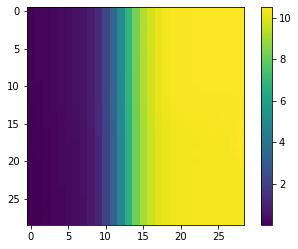

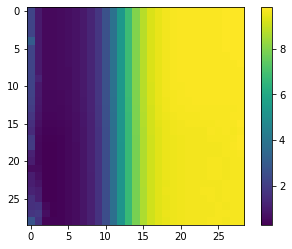

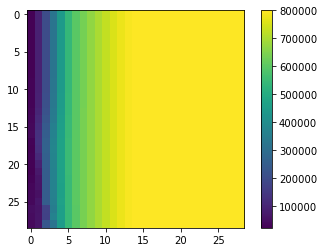

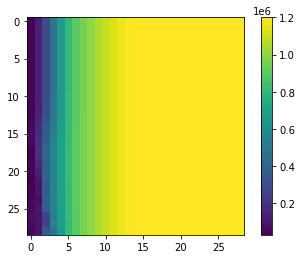

In [12]:
chi2_training=chi2_training[1:,1:]
chi2_validation=chi2_validation[1:,1:]
kishsize_training=kishsize_training[1:,1:]
kishsize_validation=kishsize_validation[1:,1:]

plt.figure()
plt.imshow(np.flip(chi2_training,axis=0))
row,col=np.where(np.flip(chi2_training,axis=0) == np.min(chi2_training))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.flip(chi2_validation,axis=0))
row,col=np.where(np.flip(chi2_validation,axis=0) == np.min(chi2_validation))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.flip(kishsize_training,axis=0)) 
row,col=np.where(np.flip(chi2_training,axis=0) == np.min(chi2_training))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.flip(kishsize_validation,axis=0)) 
row,col=np.where(np.flip(chi2_validation,axis=0) == np.min(chi2_validation))
plt.colorbar()
plt.show()